# Random Forest for An Alignment Cost-Based Classification of Log Traces

> Paper : <u>An Alignment Cost-Based Classification of Log Traces Using Machine-Learning </u><br>
> Date : June 2020 <br>
> Authors : <i>Mathilde Boltenhagen, Benjamin Chetioui, and Laurine Huber  </i> <br>
> Adapted by <i>Jennifer He<i>, December 2021 <br>

This notebook is organized as follow : <br> <br>
<b>0. Fitness function </b> 
- The lower bound fitness is a good contribution of the paper, please see the paper for more details. <br>

<b>1. Preprocessing the data:</b>
 - A function ```cleanDataForRF``` contains all the preprocessing steps. It reads the file, create the B.O.W. and the targets. 
 
<b>2. Model: </b> 
   - This is just the setting of the random forest learning model. 
   
<b>3. Cross-Validation of the method : </b>
 - A function ```runKFoldForRF``` runs a Kfold method to fit and test the model on the B.O.W.
 
<b> 4. Train and Test :</b>
- Train and test for many  m_AC values

<b> 5. Important Features :</b>
- Extract importance of features through mean decrease in impurity and feature permutation. 

## 0. Fitness

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd 
import numpy as np
np.random.seed(0)
import time

from statistics import mean

from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.losses import BinaryCrossentropy
#from tensorflow import enable_eager_execution
#enable_eager_execution() 

The commented lines were used when the frequency of the variants was incorporated in the computation of fitness.
In fact, we decided to compute the fitness and lower bound for fitness on the variants only due to the understanding of the approach.

In [2]:
def fitness(packageForFitness, minRunLength):
    '''
    This function computes the fitness for all the sequences. 
    @sequences: the sequences of words
    @costs: the real alignment cost
    @minRunLength: the minimal run in the alignment dataset
    '''
    sumTraceFitness = 0
    totTraces = 0 
    for i in packageForFitness.index:
        sumTraceFitness += (1 - (packageForFitness.realCosts[i] / ( packageForFitness.lengths[i]  + minRunLength )))#*packageForFitness.freqs[i]
        #totTraces += packageForFitness.freqs[i]
        totTraces +=1
    return sumTraceFitness / totTraces

def LB_fitness(packageForFitness, minRunLength, m_AC, indices):
    '''
    This function computes lower bound of the fitness given in the paper. 
    @sequences: the sequences of words
    @minRunLength: the minimal run in the alignment dataset
    @m_AC: needed for the lowerbound formula
    @indices: if we compute the lower bound, then we don't iterate on all the traces but only the positives. 
    '''
    sumTraceFitness = 0
    totTraces = 0 
    for i in indices:
        sumTraceFitness += (1 - ((m_AC) / ( packageForFitness.lengths[i] + minRunLength )))#*packageForFitness.freqs[i]
    for i in packageForFitness.index:
        #totTraces += packageForFitness.freqs[i]
        totTraces +=1
    return sumTraceFitness / totTraces
        

## 1. Preprocessing the data

This function takes as input an alignment dataset and its Maximal Alignment Cost and clean the data in order to get a B.O.W. and the target classes. Please, see the definition of Maximal Alignment Cost Classification for more details.

In [3]:
# Initialize the "CountVectorizer" object as a GLOBAL VARIABLE, which is scikit-learn's bag of words tool.
vectorizer = CountVectorizer(analyzer = 'word',
                            tokenizer = None,
                            preprocessor = None,
                            stop_words = None,
                            max_features = 5000)

In [4]:
def cleanDataForRF(dataFile,m_AC,vectorizer_already_trained=None): 
    '''
    Reads the file (1), specifies the target classes (2) and prepare the Bag of Words(3).
    @dataFile: (String) filename of the alignment dataset
    @m_AC: (int) maximal alignment cost classifier
    '''
    # ---- (1) yes, a bit of copy/paste... Read the file 
    data = pd.read_csv(dataFile,sep = ";", 
                   names = ["traces","tracesWithMoves","runs","runsWithMoves","costs","frequencies"])
    
    # ---- (2) create the positive and negative target depending on the m_AC parameter
    # alignment cost which interests us is greater than 10000 (other costs are just silent moves)
    # set the fitting to tmp_pos to set them latter to 1
    y = ((data["costs"] / 10000) / (m_AC+1)).astype(int)
    max_y = y.max()
    y = y.replace(0,"tmp_pos")
    y = y.replace(range(1,max_y + 1), 0)
    y = y.replace("tmp_pos",1)
    y = np.eye(2)[y.to_numpy().reshape(-1)]
    
    data["runs"] = data["runs"].fillna("")
    
    # ---- (3) prepare the Bag of Words
    traces_to_matrix = data.traces.str.split(":::",expand=True,)
    # this line takes the matrix of words, and transformed it to a list of sentences
    data_to_fit = [' '.join( [e.replace(" ","") for e in filter(None,a)]) for a in traces_to_matrix.values.tolist()]
    
    if vectorizer_already_trained :
        x = vectorizer.transform(data_to_fit).toarray()
    else :
        # then we can transform our data with the counter (it's like a one-hot-encode, right?)
        x = vectorizer.fit_transform(data_to_fit).toarray()
    
    # for fitness computation
    minLengthRun= len(data.runs.str.split(":::").min())
    lengths = data.traces.str.split(":::",expand=False,).str.len()-1
    realCosts = (data["costs"] / 10000).astype(int)
    packageForFitness = pd.DataFrame({"lengths":lengths, "realCosts": realCosts, "freqs": data.frequencies})
    
    return x, y, packageForFitness, minLengthRun, m_AC

In [5]:
# example of use
x, y, packageForFitness, minLengthRun, m_AC = cleanDataForRF("alignments/A_2012_im.csv",2)
x, y

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 5, 5, 0],
        [1, 0, 0, ..., 5, 3, 0],
        [1, 0, 0, ..., 3, 0, 0]]),
 array([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]]))

## 2. Model

Just a sklearn call. In fact, the call will be in the KFold so we can keep the best model of prediction.

## 3.  Cross-Validation of the method 

From ```KFold``` of sklearn, we do a cross-validation on the training set. The outputs are average of the accuracy and the loss (binary-cross entropy). We use the ```BinaryCrossentropy``` function of <b> Tensorflow </b> to be consistent with the other experiment. 

- In order to see if positives or negatives items have better results, we give the results for `all` the test items, only the `positive` items and only the `negative` items. 
- `loss`, `acc` and `accLossPercentage` functions have been implemented in order to reduce number of lines

In [8]:
def loss(forest, x_test, y_test):
    y_test_predict_with_proba = forest.predict_proba(x_test)[1]
    return  BinaryCrossentropy()(y_test,y_test_predict_with_proba).numpy()

def acc(forest, x_test, y_test):
    y_test_predict = forest.predict(x_test)
    return accuracy_score(y_test,y_test_predict) 

In [9]:
def accLossPercentage(forest, x, y, indices_of_test, accArr, lossArr, percentageArr=None, freqs=None,classToTest=None):
    '''
    This function fills the arrays of results accArr, lossArr and percentageArr for all the test items, or only the 
    negative items (classToTest=0) or only the positive items (classToTest=1). percentageArr is optional because it 
    is not required for the entire dataset, i.e., when we do not specify the class. 
    This works by using a dynamic programmation for the arrays. The return element is either the current accuracy in 
    case of classToTest=None, either the indices in case of classToTest!=None.
    Params:
    @forest: a trained model
    @x_test: the dataset to test
    @y_test: the target value to predict for the test dataset
    @accArr: a list of the previous accurary, or an empty list
    @lossArr: a list of the previous loss, or an empty list
    @percentageArr:  a list of the previous percentage, or an empty list
    @classToTest: 1 or 0 for positive and negative. This will find the indices of the items that belongs to the class
    '''
    if classToTest!=None:
        indices = [i for i in indices_of_test if y[i][1]==classToTest]
        if len(indices)>0:
            accArr.append(acc(forest, x[indices], y[indices]))
            lossArr.append(loss(forest, x[indices], y[indices]))
        #percentageArr.append(freqs[indices].sum()/freqs[indices_of_test].sum())
        percentageArr.append(len(indices)/len(indices_of_test))
        return indices
    else :
        accuracy = acc(forest, x[indices_of_test], y[indices_of_test])
        accArr.append(accuracy)
        lossArr.append(loss(forest, x[indices_of_test], y[indices_of_test]))
        return accuracy

In [10]:
def runKFoldForRF(numberOfFold,x,y,packageForFitness,minLengthRun, m_AC):
    startModel = time.time()
    accAll, lossAll = [], []
    accNeg, lossNeg, percentageNeg = [], [], []
    accPos, lossPos, percentagePos = [], [], []
    
    realFitness, realLBFitness, predictedLBFitness = [], [], []
    packageForFitness.reset_index(drop=True,inplace=True)
    
    runtime = []

    # use a K-fold Cross-Validation and show average Loss and average Accuracy
    kfold = KFold(numberOfFold,)
    bestmodel, bestAccuracy = None, 0
    
    for indices_of_train, indices_of_test in kfold.split(x):
        forest = RandomForestClassifier(n_estimators = 100) 
        forest.fit(x[indices_of_train], y[indices_of_train])
        
        # compute loss and accuracy on the test items
        current_accuracy = accLossPercentage(forest, x, y, indices_of_test, accAll, lossAll, )
        
        # compute loss and accuracy on the test items that are negatives
        accLossPercentage(forest, x, y, indices_of_test, accNeg, lossNeg, percentageNeg,packageForFitness.freqs, 0)

        # compute loss and accuracy on the test items that are positives
        indices_of_pos = accLossPercentage(forest, x, y, indices_of_test, accPos, lossPos, percentagePos,packageForFitness.freqs, 1) 

        # compute fitness and lower-bound
        realFitness.append(fitness(packageForFitness.iloc[indices_of_test], minLengthRun))
        
        # compute real LB, which depends on number of pos items
        if len(indices_of_pos)>0:
            realLBFitness.append(LB_fitness(packageForFitness.iloc[indices_of_test], minLengthRun, m_AC, indices_of_pos))
        
        # compute predicted LB fitness and runtime
        start = time.time()
        predictions = forest.predict(x[indices_of_test])
        runtime.append((time.time()-start)/len(indices_of_test))
        
        indices_of_predicted_as_positives = [indices_of_test[i] for i in range(0,len(predictions)) if predictions[i][1]==1]
        if len(indices_of_predicted_as_positives)>0:
            predictedLBFitness.append(LB_fitness(packageForFitness.iloc[indices_of_test], minLengthRun, m_AC, indices_of_predicted_as_positives))
            
        if bestAccuracy < current_accuracy:
            bestmodel = forest
            bestAccuracy = current_accuracy
    print("TIME:",time.time()-startModel)        
    print("[CROSS-VALIDATION]\n[ALL] Loss:", "{:.3f}".format(mean(lossAll)), "\t Acc:", "{:.3f}".format(mean(accAll)))
    print("[POSITIVE ({:.2f}%)] Loss:".format(mean(percentagePos)), "{:.3f}".format(mean(lossPos)), "\t Acc:", "{:.3f}".format(mean(accPos)))
    print("[NEGATIVE ({:.2f}%)] Loss:".format(mean(percentageNeg)), "{:.3f}".format(mean(lossNeg)),"\t Acc:", "{:.3f}".format(mean(accNeg)))
    print("Fitness {:.3f}".format(mean(realFitness)), "\t LB Fitness:", "{:.3f}\n".format(mean(realLBFitness)),"\t LB Fitness:", "{:.3f}\n".format(mean(predictedLBFitness)))
    print("Runtime (prediction per trace):{:.10f}".format(mean(runtime)))
    return bestmodel

In [10]:
# example of use
runKFoldForRF(3,x,y,packageForFitness, minLengthRun, m_AC)

2021-12-23 12:51:48.589014: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-23 12:51:48.596651: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


TIME: 2.3898229598999023
[CROSS-VALIDATION]
[ALL] Loss: 0.080 	 Acc: 0.976
[POSITIVE (0.74%)] Loss: 0.040 	 Acc: 0.981
[NEGATIVE (0.26%)] Loss: 0.185 	 Acc: 0.961
Fitness 0.950 	 LB Fitness: 0.699
 	 LB Fitness: 0.695

Runtime (prediction per trace):0.0000349155


RandomForestClassifier()

## 4. Train and Test

In this section, we launch the cross-validation on a training set and test with a different set, thanks to `train_test_split`. 

The loop gives the results for <b>different mAC values</b> from 1 to 10. 

In [16]:
filename = "A_2012_shm.csv"

for i in [2,4,6,8,10]:
    print("\n","m_AC=",i)
    
    # read the datafile, packageForFitness, minLengthRun, m_AC are needed to compute fitness and LBfitness
    x, y, packageForFitness, minLengthRun, m_AC  = cleanDataForRF("alignments/"+filename,i)
    
    # split the dataset in TRAIN and TEST sets
    X_train, X_test, y_train, y_test, packageForFitness_train, packageForFitness_test = train_test_split(x, y, packageForFitness, test_size=0.33, random_state=42)

    # ----------------------------------------------
    #                     TRAIN 
    # ----------------------------------------------
    # run the cross-validation
    bestmodel = runKFoldForRF(10, X_train, y_train, packageForFitness_train, minLengthRun, m_AC)
    
    # ----------------------------------------------
    #                     TEST 
    # ----------------------------------------------
    # use the same function as in the cross-validation but for the test set. 
    accAll, lossAll = [], []
    accNeg, lossNeg, percentageNeg   = [], [], []
    accPos, lossPos, percentagePos = [], [], []
    
    packageForFitness_test.reset_index(drop=True,inplace=True)
    print(packageForFitness_test.freqs.shape)
    #compute loss and accuracy on the test items 
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accAll, lossAll)
        
    # compute loss and accuracy on the test items that are negatives
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accNeg, lossNeg, percentageNeg,packageForFitness_test.freqs, 0)

    # compute loss and accuracy on the test items that are positives
    indices_of_pos = accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accPos, lossPos, percentagePos,packageForFitness_test.freqs, 1) 

    # compute fitness and lower-bound
    realFitness = fitness(packageForFitness_test, minLengthRun)
    if len(indices_of_pos)>0:
        realLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_pos)
        
    # compute predicted LB fitness
    predictions = bestmodel.predict(X_test)
    indices_of_predicted_as_positives = [i for i in range(0, len(X_test)) if predictions[i][1]==1]
    if len(indices_of_predicted_as_positives)>0:
        predictedLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_predicted_as_positives)
        
    print("[TEST]\n[ALL] Loss:", "{:.3f}".format(mean(lossAll)), "\t Acc:", "{:.3f}".format(mean(accAll)))
    print("[POSITIVE ({:.2f}%)] Loss:".format(mean(percentagePos)), "{:.3f}".format(mean(lossPos)), "\t Acc:", "{:.3f}".format(mean(accPos)))
    print("[NEGATIVE ({:.2f}%)] Loss:".format(mean(percentageNeg)), "{:.3f}".format(mean(lossNeg)),"\t Acc:", "{:.3f}".format(mean(accNeg)))
    print("Fitness {:.3f}".format((realFitness)), "\t LB Fitness:", "{:.3f}\n".format((realLBFitness)),"\t Predicted LB Fitness:", "{:.3f}\n".format((predictedLBFitness)))
    
    fake_x, fake_y, fake_packageForFitness, fake_minLengthRun, fake_m_AC  = cleanDataForRF("alignments/mock/"+filename,i,vectorizer_already_trained=True)

    accFake, lossFake = [], []
    accLossPercentage(bestmodel, fake_x, fake_y, range(0,len(fake_y)), accFake, lossFake)
    print("[MOCK] Loss:", "{:.3f}".format(mean(lossFake)), "\t Acc:", "{:.3f}".format(mean(accFake)))
    
    print("-------------------------------------------")



 m_AC= 2
[CROSS-VALIDATION]
[ALL] Loss: 0.011 	 Acc: 0.996
[POSITIVE (0.08%)] Loss: 0.056 	 Acc: 0.982
[NEGATIVE (0.92%)] Loss: 0.007 	 Acc: 0.997
Fitness 0.836 	 LB Fitness: 0.074
 	 LB Fitness: 0.075

Runtime (prediction per trace):0.0000536991
(1441,)
[TEST]
[ALL] Loss: 0.008 	 Acc: 0.998
[POSITIVE (0.08%)] Loss: 0.044 	 Acc: 1.000
[NEGATIVE (0.92%)] Loss: 0.005 	 Acc: 0.998
Fitness 0.837 	 LB Fitness: 0.071
 	 Predicted LB Fitness: 0.073

[MOCK] Loss: 0.206 	 Acc: 0.912
-------------------------------------------

 m_AC= 4
[CROSS-VALIDATION]
[ALL] Loss: 0.019 	 Acc: 0.996
[POSITIVE (0.20%)] Loss: 0.030 	 Acc: 0.994
[NEGATIVE (0.80%)] Loss: 0.016 	 Acc: 0.997
Fitness 0.836 	 LB Fitness: 0.174
 	 LB Fitness: 0.175

Runtime (prediction per trace):0.0000584042
(1441,)
[TEST]
[ALL] Loss: 0.023 	 Acc: 0.999
[POSITIVE (0.20%)] Loss: 0.018 	 Acc: 1.000
[NEGATIVE (0.80%)] Loss: 0.024 	 Acc: 0.998
Fitness 0.837 	 LB Fitness: 0.169
 	 Predicted LB Fitness: 0.170

[MOCK] Loss: 0.387 	 Acc: 0.

In [11]:
filename = "A_2012_shm.csv"

for i in [6]:
    print("\n","m_AC=",i)
    
    # read the datafile, packageForFitness, minLengthRun, m_AC are needed to compute fitness and LBfitness
    x, y, packageForFitness, minLengthRun, m_AC  = cleanDataForRF("alignments/"+filename,i)
    
    # split the dataset in TRAIN and TEST sets
    X_train, X_test, y_train, y_test, packageForFitness_train, packageForFitness_test = train_test_split(x, y, packageForFitness, test_size=0.33, random_state=42)

    # ----------------------------------------------
    #                     TRAIN 
    # ----------------------------------------------
    # run the cross-validation
    bestmodel = runKFoldForRF(10, X_train, y_train, packageForFitness_train, minLengthRun, m_AC)
    
    # ----------------------------------------------
    #                     TEST 
    # ----------------------------------------------
    # use the same function as in the cross-validation but for the test set. 
    accAll, lossAll = [], []
    accNeg, lossNeg, percentageNeg   = [], [], []
    accPos, lossPos, percentagePos = [], [], []
    
    packageForFitness_test.reset_index(drop=True,inplace=True)
    print(packageForFitness_test.freqs.shape)
    #compute loss and accuracy on the test items 
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accAll, lossAll)
        
    # compute loss and accuracy on the test items that are negatives
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accNeg, lossNeg, percentageNeg,packageForFitness_test.freqs, 0)

    # compute loss and accuracy on the test items that are positives
    indices_of_pos = accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accPos, lossPos, percentagePos,packageForFitness_test.freqs, 1) 

    # compute fitness and lower-bound
    realFitness = fitness(packageForFitness_test, minLengthRun)
    if len(indices_of_pos)>0:
        realLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_pos)
        
    # compute predicted LB fitness
    predictions = bestmodel.predict(X_test)
    indices_of_predicted_as_positives = [i for i in range(0, len(X_test)) if predictions[i][1]==1]
    if len(indices_of_predicted_as_positives)>0:
        predictedLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_predicted_as_positives)
        
    print("[TEST]\n[ALL] Loss:", "{:.3f}".format(mean(lossAll)), "\t Acc:", "{:.3f}".format(mean(accAll)))
    print("[POSITIVE ({:.2f}%)] Loss:".format(mean(percentagePos)), "{:.3f}".format(mean(lossPos)), "\t Acc:", "{:.3f}".format(mean(accPos)))
    print("[NEGATIVE ({:.2f}%)] Loss:".format(mean(percentageNeg)), "{:.3f}".format(mean(lossNeg)),"\t Acc:", "{:.3f}".format(mean(accNeg)))
    print("Fitness {:.3f}".format((realFitness)), "\t LB Fitness:", "{:.3f}\n".format((realLBFitness)),"\t Predicted LB Fitness:", "{:.3f}\n".format((predictedLBFitness)))
    
    fake_x, fake_y, fake_packageForFitness, fake_minLengthRun, fake_m_AC  = cleanDataForRF("alignments/mock/"+filename,i,vectorizer_already_trained=True)

    accFake, lossFake = [], []
    accLossPercentage(bestmodel, fake_x, fake_y, range(0,len(fake_y)), accFake, lossFake)
    print("[MOCK] Loss:", "{:.3f}".format(mean(lossFake)), "\t Acc:", "{:.3f}".format(mean(accFake)))
    
    print("-------------------------------------------")



 m_AC= 6
TIME: 5.177994251251221
[CROSS-VALIDATION]
[ALL] Loss: 0.158 	 Acc: 0.970
[POSITIVE (0.56%)] Loss: 0.058 	 Acc: 0.988
[NEGATIVE (0.44%)] Loss: 0.286 	 Acc: 0.946
Fitness 0.836 	 LB Fitness: 0.462
 	 LB Fitness: 0.475

Runtime (prediction per trace):0.0000822559
(1441,)
[TEST]
[ALL] Loss: 0.110 	 Acc: 0.972
[POSITIVE (0.58%)] Loss: 0.064 	 Acc: 0.980
[NEGATIVE (0.42%)] Loss: 0.173 	 Acc: 0.962
Fitness 0.837 	 LB Fitness: 0.476
 	 Predicted LB Fitness: 0.479

[MOCK] Loss: 0.517 	 Acc: 0.846
-------------------------------------------


In [30]:
filename = "A_2012_im.csv"

for i in [2]:
    print("\n","m_AC=",i)
    
    # read the datafile, packageForFitness, minLengthRun, m_AC are needed to compute fitness and LBfitness
    x, y, packageForFitness, minLengthRun, m_AC  = cleanDataForRF("alignments/"+filename,i)
    
    # split the dataset in TRAIN and TEST sets
    X_train, X_test, y_train, y_test, packageForFitness_train, packageForFitness_test = train_test_split(x, y, packageForFitness, test_size=0.33, random_state=42)

    # ----------------------------------------------
    #                     TRAIN 
    # ----------------------------------------------
    # run the cross-validation
    bestmodel = runKFoldForRF(10, X_train, y_train, packageForFitness_train, minLengthRun, m_AC)
    
    # ----------------------------------------------
    #                     TEST 
    # ----------------------------------------------
    # use the same function as in the cross-validation but for the test set. 
    accAll, lossAll = [], []
    accNeg, lossNeg, percentageNeg   = [], [], []
    accPos, lossPos, percentagePos = [], [], []
    
    packageForFitness_test.reset_index(drop=True,inplace=True)
    print(packageForFitness_test.freqs.shape)
    #compute loss and accuracy on the test items 
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accAll, lossAll)
        
    # compute loss and accuracy on the test items that are negatives
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accNeg, lossNeg, percentageNeg,packageForFitness_test.freqs, 0)

    # compute loss and accuracy on the test items that are positives
    indices_of_pos = accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accPos, lossPos, percentagePos,packageForFitness_test.freqs, 1) 

    # compute fitness and lower-bound
    realFitness = fitness(packageForFitness_test, minLengthRun)
    if len(indices_of_pos)>0:
        realLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_pos)
        
    # compute predicted LB fitness
    predictions = bestmodel.predict(X_test)
    indices_of_predicted_as_positives = [i for i in range(0, len(X_test)) if predictions[i][1]==1]
    if len(indices_of_predicted_as_positives)>0:
        predictedLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_predicted_as_positives)
        
    print("[TEST]\n[ALL] Loss:", "{:.3f}".format(mean(lossAll)), "\t Acc:", "{:.3f}".format(mean(accAll)))
    print("[POSITIVE ({:.2f}%)] Loss:".format(mean(percentagePos)), "{:.3f}".format(mean(lossPos)), "\t Acc:", "{:.3f}".format(mean(accPos)))
    print("[NEGATIVE ({:.2f}%)] Loss:".format(mean(percentageNeg)), "{:.3f}".format(mean(lossNeg)),"\t Acc:", "{:.3f}".format(mean(accNeg)))
    print("Fitness {:.3f}".format((realFitness)), "\t LB Fitness:", "{:.3f}\n".format((realLBFitness)),"\t Predicted LB Fitness:", "{:.3f}\n".format((predictedLBFitness)))
    
    fake_x, fake_y, fake_packageForFitness, fake_minLengthRun, fake_m_AC  = cleanDataForRF("alignments/mock/"+filename,i,vectorizer_already_trained=True)

    accFake, lossFake = [], []
    accLossPercentage(bestmodel, fake_x, fake_y, range(0,len(fake_y)), accFake, lossFake)
    print("[MOCK] Loss:", "{:.3f}".format(mean(lossFake)), "\t Acc:", "{:.3f}".format(mean(accFake)))
    
    print("-------------------------------------------")



 m_AC= 2
TIME: 5.233536005020142
[CROSS-VALIDATION]
[ALL] Loss: 0.067 	 Acc: 0.980
[POSITIVE (0.74%)] Loss: 0.028 	 Acc: 0.989
[NEGATIVE (0.26%)] Loss: 0.178 	 Acc: 0.952
Fitness 0.950 	 LB Fitness: 0.700
 	 LB Fitness: 0.704

Runtime (prediction per trace):0.0000828339
(1441,)
[TEST]
[ALL] Loss: 0.059 	 Acc: 0.985
[POSITIVE (0.73%)] Loss: 0.028 	 Acc: 0.993
[NEGATIVE (0.27%)] Loss: 0.142 	 Acc: 0.961
Fitness 0.950 	 LB Fitness: 0.695
 	 Predicted LB Fitness: 0.700

[MOCK] Loss: 1.102 	 Acc: 0.790
-------------------------------------------


In [56]:
 filename = "A_2012_sm.csv"

for i in [3]:
    print("\n","m_AC=",i)
    
    # read the datafile, packageForFitness, minLengthRun, m_AC are needed to compute fitness and LBfitness
    x, y, packageForFitness, minLengthRun, m_AC  = cleanDataForRF("alignments/"+filename,i)
    
    # split the dataset in TRAIN and TEST sets
    X_train, X_test, y_train, y_test, packageForFitness_train, packageForFitness_test = train_test_split(x, y, packageForFitness, test_size=0.33, random_state=42)

    # ----------------------------------------------
    #                     TRAIN 
    # ----------------------------------------------
    # run the cross-validation
    bestmodel = runKFoldForRF(10, X_train, y_train, packageForFitness_train, minLengthRun, m_AC)
    
    # ----------------------------------------------
    #                     TEST 
    # ----------------------------------------------
    # use the same function as in the cross-validation but for the test set. 
    accAll, lossAll = [], []
    accNeg, lossNeg, percentageNeg   = [], [], []
    accPos, lossPos, percentagePos = [], [], []
    
    packageForFitness_test.reset_index(drop=True,inplace=True)
    print(packageForFitness_test.freqs.shape)
    #compute loss and accuracy on the test items 
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accAll, lossAll)
        
    # compute loss and accuracy on the test items that are negatives
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accNeg, lossNeg, percentageNeg,packageForFitness_test.freqs, 0)

    # compute loss and accuracy on the test items that are positives
    indices_of_pos = accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accPos, lossPos, percentagePos,packageForFitness_test.freqs, 1) 

    # compute fitness and lower-bound
    realFitness = fitness(packageForFitness_test, minLengthRun)
    if len(indices_of_pos)>0:
        realLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_pos)
        
    # compute predicted LB fitness
    predictions = bestmodel.predict(X_test)
    indices_of_predicted_as_positives = [i for i in range(0, len(X_test)) if predictions[i][1]==1]
    if len(indices_of_predicted_as_positives)>0:
        predictedLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_predicted_as_positives)
        
    print("[TEST]\n[ALL] Loss:", "{:.3f}".format(mean(lossAll)), "\t Acc:", "{:.3f}".format(mean(accAll)))
    print("[POSITIVE ({:.2f}%)] Loss:".format(mean(percentagePos)), "{:.3f}".format(mean(lossPos)), "\t Acc:", "{:.3f}".format(mean(accPos)))
    print("[NEGATIVE ({:.2f}%)] Loss:".format(mean(percentageNeg)), "{:.3f}".format(mean(lossNeg)),"\t Acc:", "{:.3f}".format(mean(accNeg)))
    print("Fitness {:.3f}".format((realFitness)), "\t LB Fitness:", "{:.3f}\n".format((realLBFitness)),"\t Predicted LB Fitness:", "{:.3f}\n".format((predictedLBFitness)))
    
    fake_x, fake_y, fake_packageForFitness, fake_minLengthRun, fake_m_AC  = cleanDataForRF("alignments/mock/"+filename,i,vectorizer_already_trained=True)

    accFake, lossFake = [], []
    accLossPercentage(bestmodel, fake_x, fake_y, range(0,len(fake_y)), accFake, lossFake)
    print("[MOCK] Loss:", "{:.3f}".format(mean(lossFake)), "\t Acc:", "{:.3f}".format(mean(accFake)))
    
    print("-------------------------------------------")



 m_AC= 3
TIME: 3.646446943283081
[CROSS-VALIDATION]
[ALL] Loss: 0.447 	 Acc: 0.803
[POSITIVE (0.71%)] Loss: 0.242 	 Acc: 0.902
[NEGATIVE (0.29%)] Loss: 0.961 	 Acc: 0.557
Fitness 0.934 	 LB Fitness: 0.657
 	 LB Fitness: 0.709

Runtime (prediction per trace):0.0000597896
(1441,)
[TEST]
[ALL] Loss: 0.464 	 Acc: 0.822
[POSITIVE (0.73%)] Loss: 0.239 	 Acc: 0.911
[NEGATIVE (0.27%)] Loss: 1.071 	 Acc: 0.585
Fitness 0.932 	 LB Fitness: 0.670
 	 Predicted LB Fitness: 0.713

[MOCK] Loss: 0.334 	 Acc: 0.848
-------------------------------------------


In [23]:
filename = "A_2017_im.csv"

for i in [13]:
    print("\n","m_AC=",i)
    
    # read the datafile, packageForFitness, minLengthRun, m_AC are needed to compute fitness and LBfitness
    x, y, packageForFitness, minLengthRun, m_AC  = cleanDataForRF("alignments/"+filename,i)
    
    # split the dataset in TRAIN and TEST sets
    X_train, X_test, y_train, y_test, packageForFitness_train, packageForFitness_test = train_test_split(x, y, packageForFitness, test_size=0.33, random_state=42)

    # ----------------------------------------------
    #                     TRAIN 
    # ----------------------------------------------
    # run the cross-validation
    bestmodel = runKFoldForRF(10, X_train, y_train, packageForFitness_train, minLengthRun, m_AC)
    
    # ----------------------------------------------
    #                     TEST 
    # ----------------------------------------------
    # use the same function as in the cross-validation but for the test set. 
    accAll, lossAll = [], []
    accNeg, lossNeg, percentageNeg   = [], [], []
    accPos, lossPos, percentagePos = [], [], []
    
    packageForFitness_test.reset_index(drop=True,inplace=True)
    print(packageForFitness_test.freqs.shape)
    #compute loss and accuracy on the test items 
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accAll, lossAll)
        
    # compute loss and accuracy on the test items that are negatives
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accNeg, lossNeg, percentageNeg,packageForFitness_test.freqs, 0)

    # compute loss and accuracy on the test items that are positives
    indices_of_pos = accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accPos, lossPos, percentagePos,packageForFitness_test.freqs, 1) 

    # compute fitness and lower-bound
    realFitness = fitness(packageForFitness_test, minLengthRun)
    if len(indices_of_pos)>0:
        realLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_pos)
        
    # compute predicted LB fitness
    predictions = bestmodel.predict(X_test)
    indices_of_predicted_as_positives = [i for i in range(0, len(X_test)) if predictions[i][1]==1]
    if len(indices_of_predicted_as_positives)>0:
        predictedLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_predicted_as_positives)
        
    print("[TEST]\n[ALL] Loss:", "{:.3f}".format(mean(lossAll)), "\t Acc:", "{:.3f}".format(mean(accAll)))
    print("[POSITIVE ({:.2f}%)] Loss:".format(mean(percentagePos)), "{:.3f}".format(mean(lossPos)), "\t Acc:", "{:.3f}".format(mean(accPos)))
    print("[NEGATIVE ({:.2f}%)] Loss:".format(mean(percentageNeg)), "{:.3f}".format(mean(lossNeg)),"\t Acc:", "{:.3f}".format(mean(accNeg)))
    print("Fitness {:.3f}".format((realFitness)), "\t LB Fitness:", "{:.3f}\n".format((realLBFitness)),"\t Predicted LB Fitness:", "{:.3f}\n".format((predictedLBFitness)))
    
    fake_x, fake_y, fake_packageForFitness, fake_minLengthRun, fake_m_AC  = cleanDataForRF("alignments/mock/"+filename,i,vectorizer_already_trained=True)

    accFake, lossFake = [], []
    accLossPercentage(bestmodel, fake_x, fake_y, range(0,len(fake_y)), accFake, lossFake)
    print("[MOCK] Loss:", "{:.3f}".format(mean(lossFake)), "\t Acc:", "{:.3f}".format(mean(accFake)))
    
    print("-------------------------------------------")



 m_AC= 13
TIME: 46.532877683639526
[CROSS-VALIDATION]
[ALL] Loss: 0.064 	 Acc: 0.979
[POSITIVE (0.53%)] Loss: 0.039 	 Acc: 0.989
[NEGATIVE (0.47%)] Loss: 0.092 	 Acc: 0.968
Fitness 0.873 	 LB Fitness: 0.464
 	 LB Fitness: 0.472

Runtime (prediction per trace):0.0001283771
(5257,)
[TEST]
[ALL] Loss: 0.059 	 Acc: 0.976
[POSITIVE (0.53%)] Loss: 0.044 	 Acc: 0.983
[NEGATIVE (0.47%)] Loss: 0.077 	 Acc: 0.967
Fitness 0.874 	 LB Fitness: 0.463
 	 Predicted LB Fitness: 0.468

[MOCK] Loss: 0.440 	 Acc: 0.827
-------------------------------------------


In [54]:
filename = "A_2017_sm.csv"

for i in [13]:
    print("\n","m_AC=",i)
    
    # read the datafile, packageForFitness, minLengthRun, m_AC are needed to compute fitness and LBfitness
    x, y, packageForFitness, minLengthRun, m_AC  = cleanDataForRF("alignments/"+filename,i)
    
    # split the dataset in TRAIN and TEST sets
    X_train, X_test, y_train, y_test, packageForFitness_train, packageForFitness_test = train_test_split(x, y, packageForFitness, test_size=0.33, random_state=42)

    # ----------------------------------------------
    #                     TRAIN 
    # ----------------------------------------------
    # run the cross-validation
    bestmodel = runKFoldForRF(10, X_train, y_train, packageForFitness_train, minLengthRun, m_AC)
    
    # ----------------------------------------------
    #                     TEST 
    # ----------------------------------------------
    # use the same function as in the cross-validation but for the test set. 
    accAll, lossAll = [], []
    accNeg, lossNeg, percentageNeg   = [], [], []
    accPos, lossPos, percentagePos = [], [], []
    
    packageForFitness_test.reset_index(drop=True,inplace=True)
    print(packageForFitness_test.freqs.shape)
    #compute loss and accuracy on the test items 
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accAll, lossAll)
        
    # compute loss and accuracy on the test items that are negatives
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accNeg, lossNeg, percentageNeg,packageForFitness_test.freqs, 0)

    # compute loss and accuracy on the test items that are positives
    indices_of_pos = accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accPos, lossPos, percentagePos,packageForFitness_test.freqs, 1) 

    # compute fitness and lower-bound
    realFitness = fitness(packageForFitness_test, minLengthRun)
    if len(indices_of_pos)>0:
        realLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_pos)
        
    # compute predicted LB fitness
    predictions = bestmodel.predict(X_test)
    indices_of_predicted_as_positives = [i for i in range(0, len(X_test)) if predictions[i][1]==1]
    if len(indices_of_predicted_as_positives)>0:
        predictedLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_predicted_as_positives)
        
    print("[TEST]\n[ALL] Loss:", "{:.3f}".format(mean(lossAll)), "\t Acc:", "{:.3f}".format(mean(accAll)))
    print("[POSITIVE ({:.2f}%)] Loss:".format(mean(percentagePos)), "{:.3f}".format(mean(lossPos)), "\t Acc:", "{:.3f}".format(mean(accPos)))
    print("[NEGATIVE ({:.2f}%)] Loss:".format(mean(percentageNeg)), "{:.3f}".format(mean(lossNeg)),"\t Acc:", "{:.3f}".format(mean(accNeg)))
    print("Fitness {:.3f}".format((realFitness)), "\t LB Fitness:", "{:.3f}\n".format((realLBFitness)),"\t Predicted LB Fitness:", "{:.3f}\n".format((predictedLBFitness)))
    
    fake_x, fake_y, fake_packageForFitness, fake_minLengthRun, fake_m_AC  = cleanDataForRF("alignments/mock/"+filename,i,vectorizer_already_trained=True)

    accFake, lossFake = [], []
    accLossPercentage(bestmodel, fake_x, fake_y, range(0,len(fake_y)), accFake, lossFake)
    print("[MOCK] Loss:", "{:.3f}".format(mean(lossFake)), "\t Acc:", "{:.3f}".format(mean(accFake)))
    
    print("-------------------------------------------")



 m_AC= 13
TIME: 7.831460952758789
[CROSS-VALIDATION]
[ALL] Loss: 0.057 	 Acc: 0.982
[POSITIVE (0.52%)] Loss: 0.038 	 Acc: 0.989
[NEGATIVE (0.48%)] Loss: 0.078 	 Acc: 0.975
Fitness 0.817 	 LB Fitness: 0.415
 	 LB Fitness: 0.420

Runtime (prediction per trace):0.0000276896
(5257,)
[TEST]
[ALL] Loss: 0.050 	 Acc: 0.986
[POSITIVE (0.52%)] Loss: 0.032 	 Acc: 0.992
[NEGATIVE (0.48%)] Loss: 0.070 	 Acc: 0.978
Fitness 0.819 	 LB Fitness: 0.415
 	 Predicted LB Fitness: 0.421

[MOCK] Loss: 0.416 	 Acc: 0.822
-------------------------------------------


In [53]:
filename = "A_2017_shm.csv"

for i in [14]:
    print("\n","m_AC=",i)
    
    # read the datafile, packageForFitness, minLengthRun, m_AC are needed to compute fitness and LBfitness
    x, y, packageForFitness, minLengthRun, m_AC  = cleanDataForRF("alignments/"+filename,i)
    
    # split the dataset in TRAIN and TEST sets
    X_train, X_test, y_train, y_test, packageForFitness_train, packageForFitness_test = train_test_split(x, y, packageForFitness, test_size=0.33, random_state=42)

    # ----------------------------------------------
    #                     TRAIN 
    # ----------------------------------------------
    # run the cross-validation
    bestmodel = runKFoldForRF(10, X_train, y_train, packageForFitness_train, minLengthRun, m_AC)
    
    # ----------------------------------------------
    #                     TEST 
    # ----------------------------------------------
    # use the same function as in the cross-validation but for the test set. 
    accAll, lossAll = [], []
    accNeg, lossNeg, percentageNeg   = [], [], []
    accPos, lossPos, percentagePos = [], [], []
    
    packageForFitness_test.reset_index(drop=True,inplace=True)
    print(packageForFitness_test.freqs.shape)
    #compute loss and accuracy on the test items 
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accAll, lossAll)
        
    # compute loss and accuracy on the test items that are negatives
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accNeg, lossNeg, percentageNeg,packageForFitness_test.freqs, 0)

    # compute loss and accuracy on the test items that are positives
    indices_of_pos = accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accPos, lossPos, percentagePos,packageForFitness_test.freqs, 1) 

    # compute fitness and lower-bound
    realFitness = fitness(packageForFitness_test, minLengthRun)
    if len(indices_of_pos)>0:
        realLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_pos)
        
    # compute predicted LB fitness
    predictions = bestmodel.predict(X_test)
    indices_of_predicted_as_positives = [i for i in range(0, len(X_test)) if predictions[i][1]==1]
    if len(indices_of_predicted_as_positives)>0:
        predictedLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_predicted_as_positives)
        
    print("[TEST]\n[ALL] Loss:", "{:.3f}".format(mean(lossAll)), "\t Acc:", "{:.3f}".format(mean(accAll)))
    print("[POSITIVE ({:.2f}%)] Loss:".format(mean(percentagePos)), "{:.3f}".format(mean(lossPos)), "\t Acc:", "{:.3f}".format(mean(accPos)))
    print("[NEGATIVE ({:.2f}%)] Loss:".format(mean(percentageNeg)), "{:.3f}".format(mean(lossNeg)),"\t Acc:", "{:.3f}".format(mean(accNeg)))
    print("Fitness {:.3f}".format((realFitness)), "\t LB Fitness:", "{:.3f}\n".format((realLBFitness)),"\t Predicted LB Fitness:", "{:.3f}\n".format((predictedLBFitness)))
    
    fake_x, fake_y, fake_packageForFitness, fake_minLengthRun, fake_m_AC  = cleanDataForRF("alignments/mock/"+filename,i,vectorizer_already_trained=True)

    accFake, lossFake = [], []
    accLossPercentage(bestmodel, fake_x, fake_y, range(0,len(fake_y)), accFake, lossFake)
    print("[MOCK] Loss:", "{:.3f}".format(mean(lossFake)), "\t Acc:", "{:.3f}".format(mean(accFake)))
    
    print("-------------------------------------------")



 m_AC= 14
TIME: 7.480311155319214
[CROSS-VALIDATION]
[ALL] Loss: 0.061 	 Acc: 0.981
[POSITIVE (0.52%)] Loss: 0.038 	 Acc: 0.988
[NEGATIVE (0.48%)] Loss: 0.086 	 Acc: 0.974
Fitness 0.794 	 LB Fitness: 0.402
 	 LB Fitness: 0.406

Runtime (prediction per trace):0.0000274070
(5257,)
[TEST]
[ALL] Loss: 0.051 	 Acc: 0.984
[POSITIVE (0.52%)] Loss: 0.038 	 Acc: 0.990
[NEGATIVE (0.48%)] Loss: 0.066 	 Acc: 0.978
Fitness 0.794 	 LB Fitness: 0.400
 	 Predicted LB Fitness: 0.404

[MOCK] Loss: 0.426 	 Acc: 0.815
-------------------------------------------


In [33]:
filename = "A_2019_im.csv"

for i in [6]:
    print("\n","m_AC=",i)
    
    # read the datafile, packageForFitness, minLengthRun, m_AC are needed to compute fitness and LBfitness
    x, y, packageForFitness, minLengthRun, m_AC  = cleanDataForRF("alignments/"+filename,i)
    
    # split the dataset in TRAIN and TEST sets
    X_train, X_test, y_train, y_test, packageForFitness_train, packageForFitness_test = train_test_split(x, y, packageForFitness, test_size=0.33, random_state=42)

    # ----------------------------------------------
    #                     TRAIN 
    # ----------------------------------------------
    # run the cross-validation
    bestmodel = runKFoldForRF(10, X_train, y_train, packageForFitness_train, minLengthRun, m_AC)
    
    # ----------------------------------------------
    #                     TEST 
    # ----------------------------------------------
    # use the same function as in the cross-validation but for the test set. 
    accAll, lossAll = [], []
    accNeg, lossNeg, percentageNeg   = [], [], []
    accPos, lossPos, percentagePos = [], [], []
    
    packageForFitness_test.reset_index(drop=True,inplace=True)
    print(packageForFitness_test.freqs.shape)
    #compute loss and accuracy on the test items 
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accAll, lossAll)
        
    # compute loss and accuracy on the test items that are negatives
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accNeg, lossNeg, percentageNeg,packageForFitness_test.freqs, 0)

    # compute loss and accuracy on the test items that are positives
    indices_of_pos = accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accPos, lossPos, percentagePos,packageForFitness_test.freqs, 1) 

    # compute fitness and lower-bound
    realFitness = fitness(packageForFitness_test, minLengthRun)
    if len(indices_of_pos)>0:
        realLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_pos)
        
    # compute predicted LB fitness
    predictions = bestmodel.predict(X_test)
    indices_of_predicted_as_positives = [i for i in range(0, len(X_test)) if predictions[i][1]==1]
    if len(indices_of_predicted_as_positives)>0:
        predictedLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_predicted_as_positives)
        
    print("[TEST]\n[ALL] Loss:", "{:.3f}".format(mean(lossAll)), "\t Acc:", "{:.3f}".format(mean(accAll)))
    print("[POSITIVE ({:.2f}%)] Loss:".format(mean(percentagePos)), "{:.3f}".format(mean(lossPos)), "\t Acc:", "{:.3f}".format(mean(accPos)))
    print("[NEGATIVE ({:.2f}%)] Loss:".format(mean(percentageNeg)), "{:.3f}".format(mean(lossNeg)),"\t Acc:", "{:.3f}".format(mean(accNeg)))
    print("Fitness {:.3f}".format((realFitness)), "\t LB Fitness:", "{:.3f}\n".format((realLBFitness)),"\t Predicted LB Fitness:", "{:.3f}\n".format((predictedLBFitness)))
    
    fake_x, fake_y, fake_packageForFitness, fake_minLengthRun, fake_m_AC  = cleanDataForRF("alignments/mock/"+filename,i,vectorizer_already_trained=True)

    accFake, lossFake = [], []
    accLossPercentage(bestmodel, fake_x, fake_y, range(0,len(fake_y)), accFake, lossFake)
    print("[MOCK] Loss:", "{:.3f}".format(mean(lossFake)), "\t Acc:", "{:.3f}".format(mean(accFake)))
    
    print("-------------------------------------------")



 m_AC= 6
TIME: 9.792143106460571
[CROSS-VALIDATION]
[ALL] Loss: 0.110 	 Acc: 0.964
[POSITIVE (0.54%)] Loss: 0.046 	 Acc: 0.990
[NEGATIVE (0.46%)] Loss: 0.185 	 Acc: 0.933
Fitness 0.563 	 LB Fitness: 0.333
 	 LB Fitness: 0.349

Runtime (prediction per trace):0.0000459488
(3952,)
[TEST]
[ALL] Loss: 0.099 	 Acc: 0.958
[POSITIVE (0.53%)] Loss: 0.055 	 Acc: 0.985
[NEGATIVE (0.47%)] Loss: 0.150 	 Acc: 0.927
Fitness 0.561 	 LB Fitness: 0.328
 	 Predicted LB Fitness: 0.344

[MOCK] Loss: 0.045 	 Acc: 0.988
-------------------------------------------


In [11]:
filename = "A_2020_im.csv"

for i in [2,6]:
    print("\n","m_AC=",i)
    
    # read the datafile, packageForFitness, minLengthRun, m_AC are needed to compute fitness and LBfitness
    x, y, packageForFitness, minLengthRun, m_AC  = cleanDataForRF("alignments/"+filename,i)
    
    # split the dataset in TRAIN and TEST sets
    X_train, X_test, y_train, y_test, packageForFitness_train, packageForFitness_test = train_test_split(x, y, packageForFitness, test_size=0.33, random_state=42)

    # ----------------------------------------------
    #                     TRAIN 
    # ----------------------------------------------
    # run the cross-validation
    bestmodel = runKFoldForRF(10, X_train, y_train, packageForFitness_train, minLengthRun, m_AC)
    
    # ----------------------------------------------
    #                     TEST 
    # ----------------------------------------------
    # use the same function as in the cross-validation but for the test set. 
    accAll, lossAll = [], []
    accNeg, lossNeg, percentageNeg   = [], [], []
    accPos, lossPos, percentagePos = [], [], []
    
    packageForFitness_test.reset_index(drop=True,inplace=True)
    print(packageForFitness_test.freqs.shape)
    #compute loss and accuracy on the test items 
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accAll, lossAll)
        
    # compute loss and accuracy on the test items that are negatives
    accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accNeg, lossNeg, percentageNeg,packageForFitness_test.freqs, 0)

    # compute loss and accuracy on the test items that are positives
    indices_of_pos = accLossPercentage(bestmodel, X_test, y_test, list(range(0,len(y_test))), accPos, lossPos, percentagePos,packageForFitness_test.freqs, 1) 

    # compute fitness and lower-bound
    realFitness = fitness(packageForFitness_test, minLengthRun)
    if len(indices_of_pos)>0:
        realLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_pos)
        
    # compute predicted LB fitness
    predictions = bestmodel.predict(X_test)
    indices_of_predicted_as_positives = [i for i in range(0, len(X_test)) if predictions[i][1]==1]
    if len(indices_of_predicted_as_positives)>0:
        predictedLBFitness = LB_fitness(packageForFitness_test, minLengthRun, m_AC, indices_of_predicted_as_positives)
        
    print("[TEST]\n[ALL] Loss:", "{:.3f}".format(mean(lossAll)), "\t Acc:", "{:.3f}".format(mean(accAll)))
    print("[POSITIVE ({:.2f}%)] Loss:".format(mean(percentagePos)), "{:.3f}".format(mean(lossPos)), "\t Acc:", "{:.3f}".format(mean(accPos)))
    print("[NEGATIVE ({:.2f}%)] Loss:".format(mean(percentageNeg)), "{:.3f}".format(mean(lossNeg)),"\t Acc:", "{:.3f}".format(mean(accNeg)))
    print("Fitness {:.3f}".format((realFitness)), "\t LB Fitness:", "{:.3f}\n".format((realLBFitness)),"\t Predicted LB Fitness:", "{:.3f}\n".format((predictedLBFitness)))
    
    fake_x, fake_y, fake_packageForFitness, fake_minLengthRun, fake_m_AC  = cleanDataForRF("alignments/mock/"+filename,i,vectorizer_already_trained=True)

    accFake, lossFake = [], []
    accLossPercentage(bestmodel, fake_x, fake_y, range(0,len(fake_y)), accFake, lossFake)
    print("[MOCK] Loss:", "{:.3f}".format(mean(lossFake)), "\t Acc:", "{:.3f}".format(mean(accFake)))
    
    print("-------------------------------------------")



 m_AC= 2


2021-12-31 16:35:31.914926: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-31 16:35:31.917283: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


TIME: 4.24606990814209
[CROSS-VALIDATION]
[ALL] Loss: 0.179 	 Acc: 0.904
[POSITIVE (0.12%)] Loss: 0.729 	 Acc: 0.615
[NEGATIVE (0.88%)] Loss: 0.109 	 Acc: 0.940
Fitness 0.598 	 LB Fitness: 0.099
 	 LB Fitness: 0.107

Runtime (prediction per trace):0.0002240157
(488,)
[TEST]
[ALL] Loss: 0.336 	 Acc: 0.863
[POSITIVE (0.12%)] Loss: 1.071 	 Acc: 0.683
[NEGATIVE (0.88%)] Loss: 0.233 	 Acc: 0.888
Fitness 0.596 	 LB Fitness: 0.102
 	 Predicted LB Fitness: 0.152

[MOCK] Loss: 0.138 	 Acc: 0.975
-------------------------------------------

 m_AC= 6
TIME: 4.6258931159973145
[CROSS-VALIDATION]
[ALL] Loss: 0.400 	 Acc: 0.874
[POSITIVE (0.52%)] Loss: 0.223 	 Acc: 0.903
[NEGATIVE (0.48%)] Loss: 0.564 	 Acc: 0.845
Fitness 0.598 	 LB Fitness: 0.276
 	 LB Fitness: 0.289

Runtime (prediction per trace):0.0002007191
(488,)
[TEST]
[ALL] Loss: 0.646 	 Acc: 0.834
[POSITIVE (0.50%)] Loss: 0.201 	 Acc: 0.890
[NEGATIVE (0.50%)] Loss: 1.097 	 Acc: 0.777
Fitness 0.596 	 LB Fitness: 0.264
 	 Predicted LB Fitness:

# 5. Important Features

In [56]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

filename_features = "A_2012_im.csv"

In [33]:
# ---- (3) prepare the sequences of activities 
data = pd.read_csv("alignments/"+filename_features,sep = ";", 
                   names = ["traces","tracesWithMoves","runs","runsWithMoves","costs","frequencies"])

traces_to_matrix = data.traces.str.split(":::",expand=True,)
number_of_traces, max_len = traces_to_matrix.shape
print("Number of traces:", number_of_traces, "\nMax len of traces:", max_len) 

# transform the matrix to a serie
traces_to_serie = pd.concat([traces_to_matrix[i] for i in range(0,max_len)], axis=0, 
                                      ignore_index=True, sort=False)
# from the serie, it's easy to get unique words
index_to_word = list(filter(None,(traces_to_serie).unique()))

Number of traces: 4366 
Max len of traces: 176


In [44]:
for feature in zip(index_to_word, bestmodel.feature_importances_):
    print(feature)

('A_SUBMITTED', 0.0034326324172665266)
('A_PARTLYSUBMITTED', 0.03489566067128507)
('A_DECLINED', 0.04257744585181327)
('W_Afhandelen leads', 0.018971472502290577)
('A_PREACCEPTED', 0.11612649635179158)
('W_Beoordelen fraude', 0.005427285162390865)
('W_Completeren aanvraag', 0.0)
('A_ACCEPTED', 2.6864004543919435e-05)
('A_CANCELLED', 0.03409922006943769)
('O_SELECTED', 0.0)
('A_FINALIZED', 0.033199062135398624)
('O_CREATED', 0.03803478209188419)
('O_SENT', 0.03179475059008037)
('W_Nabellen offertes', 0.1131267860160699)
('O_CANCELLED', 0.02789485920205668)
('O_SENT_BACK', 0.04778612076634601)
('O_DECLINED', 0.13852792992380544)
('W_Valideren aanvraag', 0.008436337924589494)
('O_ACCEPTED', 0.0009918966034164203)
('W_Nabellen incomplete dossiers', 0.013621149656769884)
('A_APPROVED', 0.10718070880645363)
('A_REGISTERED', 0.04607251510762934)
('A_ACTIVATED', 0.13653234210687323)
('W_Wijzigen contractgegevens', 0.0012436820378072743)


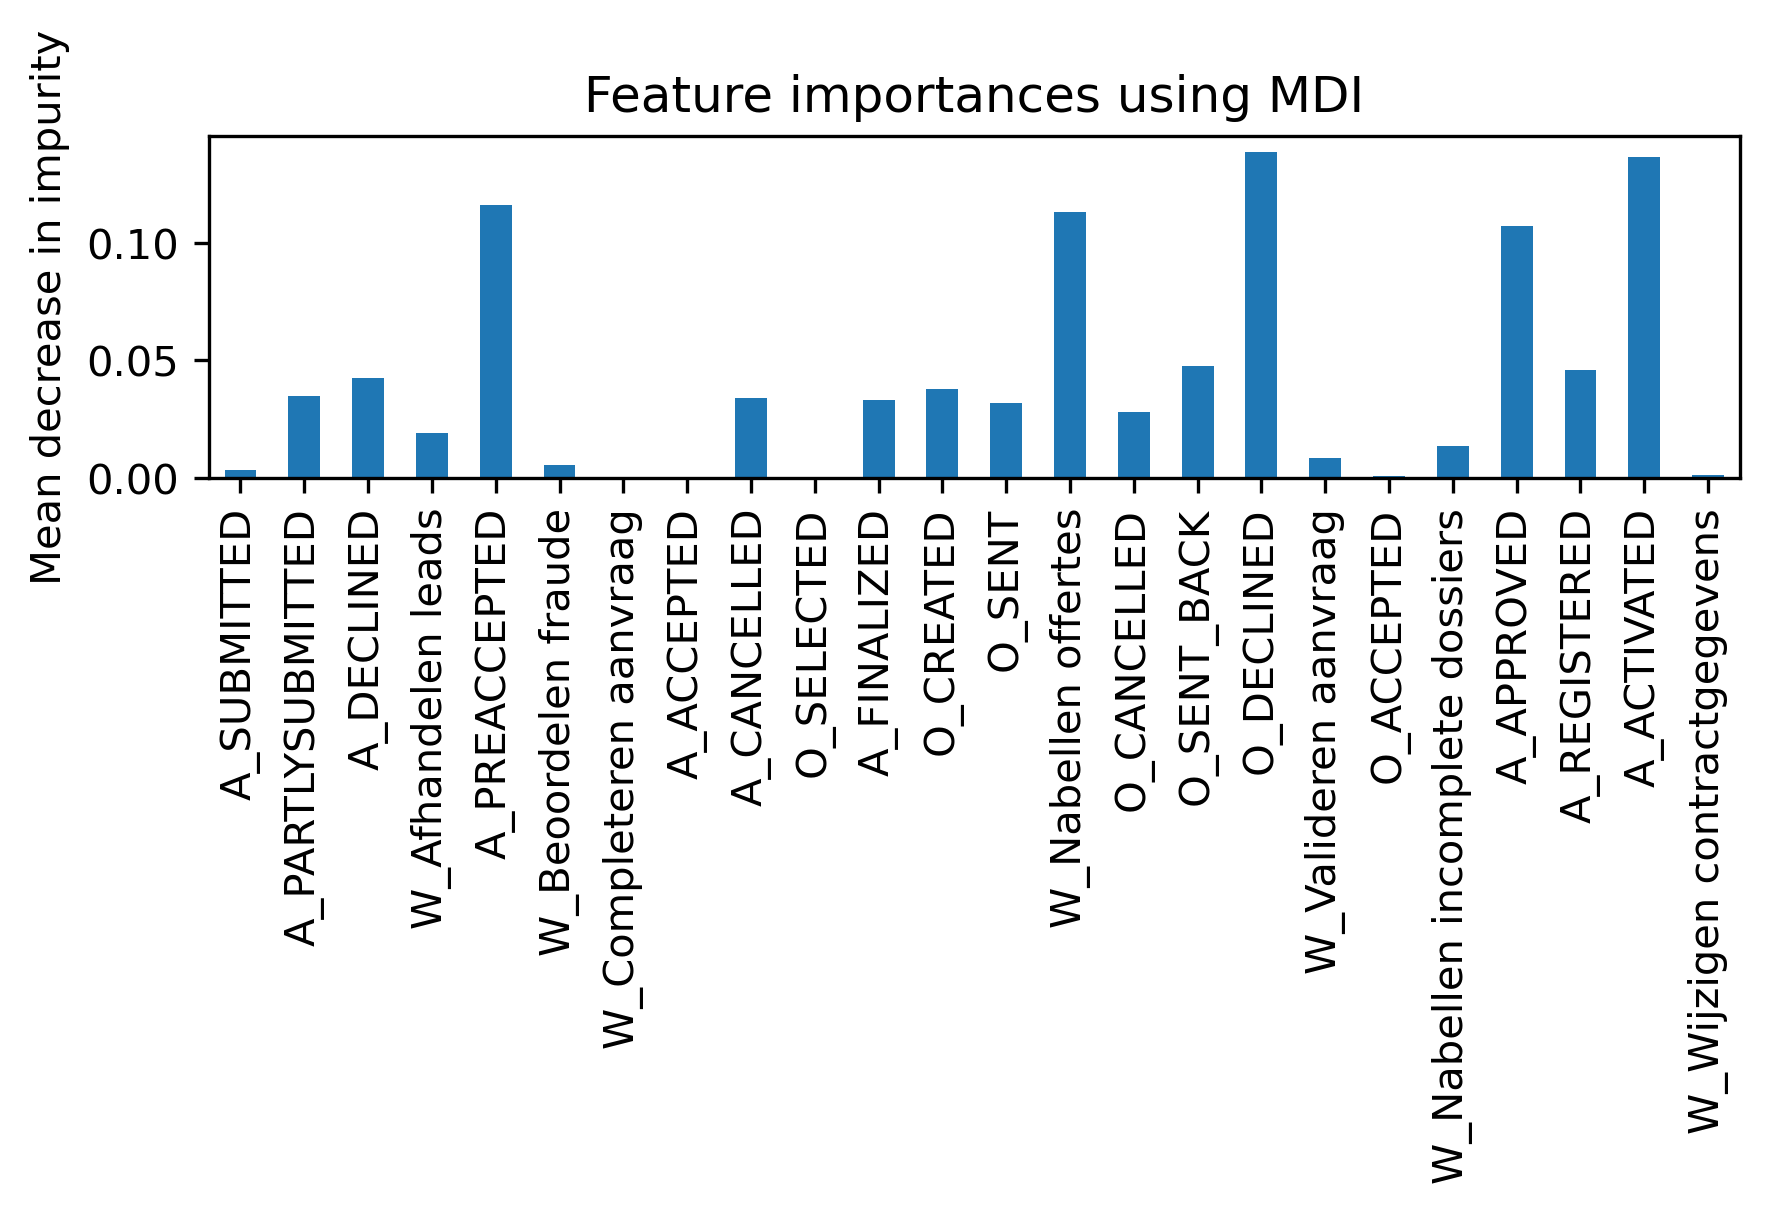

In [58]:
import pandas as pd

forest_importances = pd.Series(bestmodel.feature_importances_, index=index_to_word)

fig, ax = plt.subplots()
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [54]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    bestmodel, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=index_to_word)

In [49]:
forest_importances

A_SUBMITTED                       0.003433
A_PARTLYSUBMITTED                 0.034896
A_DECLINED                        0.042577
W_Afhandelen leads                0.018971
A_PREACCEPTED                     0.116126
W_Beoordelen fraude               0.005427
W_Completeren aanvraag            0.000000
A_ACCEPTED                        0.000027
A_CANCELLED                       0.034099
O_SELECTED                        0.000000
A_FINALIZED                       0.033199
O_CREATED                         0.038035
O_SENT                            0.031795
W_Nabellen offertes               0.113127
O_CANCELLED                       0.027895
O_SENT_BACK                       0.047786
O_DECLINED                        0.138528
W_Valideren aanvraag              0.008436
O_ACCEPTED                        0.000992
W_Nabellen incomplete dossiers    0.013621
A_APPROVED                        0.107181
A_REGISTERED                      0.046073
A_ACTIVATED                       0.136532
W_Wijzigen 

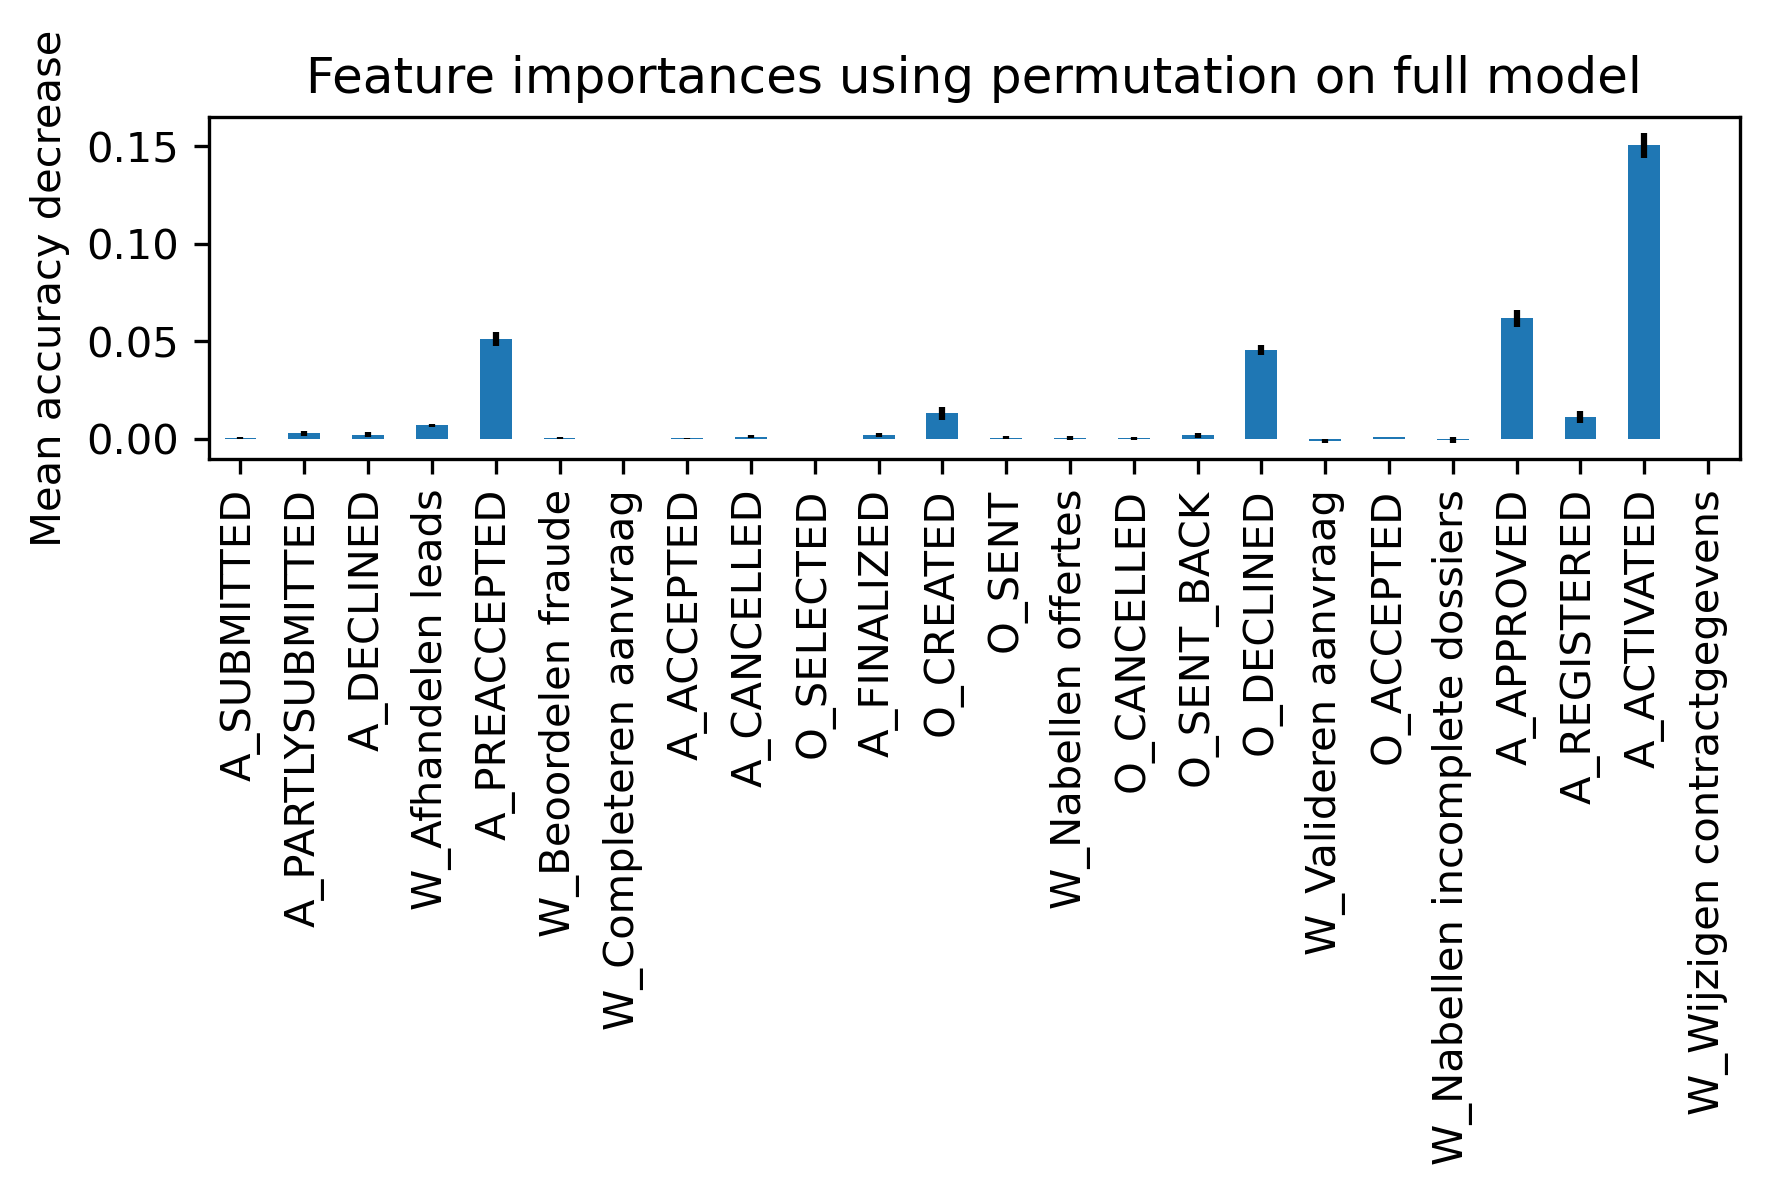

In [57]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()